In [2]:
from IPython.display import display, HTML, clear_output
display(HTML("<style>.container { width:98% !important; }</style>"))

# Additional code so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

import os
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from tqdm import tqdm
import cv2

from ui_utils import RegDataFilterUI
import degradation_utils as hp
from ipywidgets import widgets, Layout, HBox, VBox

In [2]:
# path for image and mask
# img_dir = "../segmentation/data/bdd100k/images/val/"
# mask_dir = "../segmentation/data/bdd100k/generated_masks_v0_1/val/"

# annotations_dir = "../regression/data/bdd100k/annotations/val/"
# output_dir = "./output/filtered_annotations/val/"

d_type = "train"
img_dir = f"/cs6945share/retro_project/bdd100k/images/{d_type}/"
mask_dir = f"/cs6945share/retro_project/bdd100k/generated_masks_v0_3/masks_v3/{d_type}/"

annotations_dir = f"/cs6945share/retro_project/regression_bdd100k/annotations/{d_type}/"
output_dir = f"./output/filtered_annotations/{d_type}/"

reg_ui = RegDataFilterUI(img_dir=img_dir, mask_dir=mask_dir, annot_dir=annotations_dir, output_dir=output_dir)

In [3]:
reg_ui.display_UI()

In [ ]:
# 40c3d445-a5194bdd.jpg

# Save segements 

In [3]:
d_type = "val"
img_dir = f"/cs6945share/retro_project/bdd100k/images/{d_type}/"
annotations_dir = f"/cs6945share/retro_project/classification_bdd100k/filtered_annotations/{d_type}/"
segments_output_dir = f"/cs6945share/retro_project/classification_bdd100k/segments/{d_type}/"

filtered_label_file =  f"/cs6945share/retro_project/classification_bdd100k/filtered_annotations/{d_type}/filtered_img_names.txt"

In [4]:
# ensure all necessary folders are available
os.makedirs(segments_output_dir, exist_ok=True)

try:
    # read list of image names filtered by the user
    with open(filtered_label_file, "r") as file:
        content = file.read()
        img_names = content.split("\n")
        img_names = list(filter(None, img_names))   # remove null strings

except FileNotFoundError:
    print(f"Error: File not found at {label_file}")
    img_names = []

In [5]:
segment_label_list = []
for img_name in tqdm(img_names):
    
    # read image and mask
    img_path = os.path.join(img_dir, img_name)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    file_initials = ".".join(img_name.split(".")[:-1])  # remove extension 

    # load annotations
    annot_name = f"{file_initials}.json"
    fp = os.path.join(annotations_dir, annot_name)
    with open(fp, 'r') as file:
        annot_data = json.load(file)

    # save each annotations segments 
    segment_labels = []
    for annot in annot_data["annotations"]:

        idx = annot["id"]
        target = annot.get("manual_checked_degradation_target", -1)
        if target >= 0:

            coco_bbox = annot["bounding_box"]   # get bbox (top-left-x, top-left-y, width, height)
            xmin, ymin, xmax, ymax = hp.box_coco_to_corner(coco_bbox)

            # get segment in original image
            segment = img[ymin:ymax + 1, xmin:xmax + 1].copy()      # get specific segment crop

            # Write the segment to the output dir
            segment_name = f"{file_initials}_{idx}.png"
            segment_path = os.path.join(segments_output_dir, segment_name)
            segment = cv2.cvtColor(segment, cv2.COLOR_BGR2RGB)
            cv2.imwrite(segment_path, segment)

            segment_info = {
                    "name": segment_name,
                    "degradation_target": target
                }

            segment_labels.append(segment_info.copy())
    
    segment_label_list.extend(segment_labels)

# convert segments labels to csv and save
segment_df = pd.DataFrame(segment_label_list)
fn = f"degradation_segment_labels_{d_type}.csv"
fn = os.path.join(segments_output_dir, fn)
segment_df.to_csv(fn, index=False)
print(f"Segment label file saved at {fn}")

100%|██████████| 70/70 [00:04<00:00, 16.40it/s]

Segment label file saved at /cs6945share/retro_project/classification_bdd100k/segments/val/degradation_segment_labels_val.csv


In [48]:
# !mv /cs6945share/retro_project/classification_bdd100k/segments/val/degradation_segment_labels_val.csv /cs6945share/retro_project/classification_bdd100k/segments/degradation_segment_labels_val.csv

In [14]:
# load and test some segments as a check
d_type = "train"
segments_dir = f"/cs6945share/retro_project/classification_bdd100k/segments/{d_type}/"
path = f"/cs6945share/retro_project/classification_bdd100k/segments/degradation_segment_labels_{d_type}.csv"
df = pd.read_csv(path)
print(df.shape)
df.head(3)

(1050, 2)


,name,degradation_target
0,0000f77c-62c2a288_2.png,1
1,0000f77c-62c2a288_4.png,0
2,0000f77c-cb820c98_1.png,0


In [12]:
df["degradation_target"].value_counts(normalize=True)

0    0.617347
1    0.265306
2    0.117347
Name: degradation_target, dtype: float64

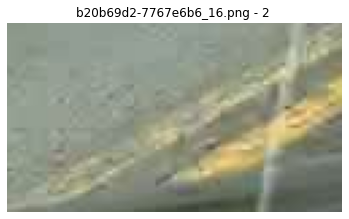

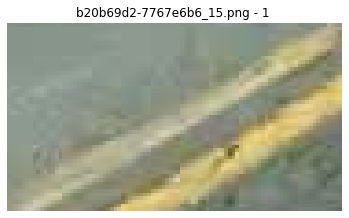

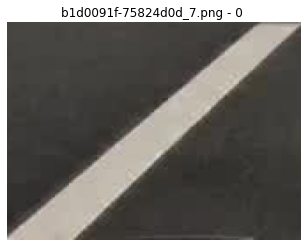

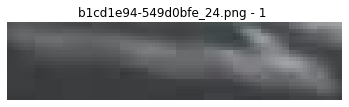

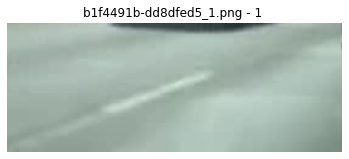

In [13]:
samples = 5
temp = df.sample(samples)

for _, row in temp.iterrows():

    img_name = row["name"]
    target = row["degradation_target"]
    
     # read image and mask
    img_path = os.path.join(segments_dir, img_name)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.imshow(img)
    plt.axis("off")
    plt.title(f"{img_name} - {target} ")
    plt.show()


In [22]:
temp = df.sample(100)
t = temp["name"].values

In [25]:
t2 = df.loc[~df["name"].isin(t)]

In [26]:
t2.to_csv("/cs6945share/retro_project/classification_bdd100k/segments/degradation_segment_labels_train_vtest.csv", index=False)

In [27]:
temp.to_csv("/cs6945share/retro_project/classification_bdd100k/segments/degradation_segment_labels_val_vtest.csv", index=False)